<a href="https://colab.research.google.com/github/u2200579/FreeCodeCamp-Machine-Learning-w-Python/blob/main/Copy_of_fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2023-02-14 19:08:03--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.16’

insurance.csv.16    100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2023-02-14 19:08:03 (47.4 MB/s) - ‘insurance.csv.16’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
dataset.isna().sum() # check the number of nan values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [ ]:
# drop nan rows if it exists
dataset = dataset.dropna()

# manage categorical columns
categorical_cols=['sex', 'smoker', 'region']

for categorical_col in categorical_cols:
  dataset[categorical_col] = dataset[categorical_col].map({'male':'male', 'yes': 'smoker', 'northeast':'NE', 'southeast':'SE', 'southwest':'SW', 'northwest':'NW'})
  dataset = pd.get_dummies(dataset, columns=[categorical_col], prefix='', prefix_sep='')
  
dataset.tail()

,age,bmi,children,expenses,male,smoker,NE,NW,SE,SW
1333,50,31.0,3,10600.55,1,0,0,1,0,0
1334,18,31.9,0,2205.98,0,0,1,0,0,0
1335,18,36.9,0,1629.83,0,0,0,0,1,0
1336,21,25.8,0,2007.95,0,0,0,0,0,1
1337,61,29.1,0,29141.36,0,1,0,1,0,0


In [ ]:
dataset.corr()

,age,bmi,children,expenses,male,smoker,NE,NW,SE,SW
age,1.000000,0.109341,0.042469,0.299008,-0.020856,-0.025019,0.002475,-0.000407,-0.011642,0.010016
bmi,0.109341,1.000000,0.012645,0.198576,0.046380,0.003968,-0.138091,-0.135992,0.270144,-0.006398
children,0.042469,0.012645,1.000000,0.067998,0.017163,0.007673,-0.022808,0.024806,-0.023066,0.021914
expenses,0.299008,0.198576,0.067998,1.000000,0.057292,0.787251,0.006349,-0.039905,0.073982,-0.043210
male,-0.020856,0.046380,0.017163,0.057292,1.000000,0.076185,-0.002425,-0.011156,0.017117,-0.004184
smoker,-0.025019,0.003968,0.007673,0.787251,0.076185,1.000000,0.002811,-0.036945,0.068498,-0.036945
NE,0.002475,-0.138091,-0.022808,0.006349,-0.002425,0.002811,1.000000,-0.320177,-0.345561,-0.320177
NW,-0.000407,-0.135992,0.024806,-0.039905,-0.011156,-0.036945,-0.320177,1.000000,-0.346265,-0.320829
SE,-0.011642,0.270144,-0.023066,0.073982,0.017117,0.068498,-0.345561,-0.346265,1.000000,-0.346265
SW,0.010016,-0.006398,0.021914,-0.043210,-0.004184,-0.036945,-0.320177,-0.320829,-0.346265,1.000000


In [ ]:
dataset.describe()

,age,bmi,children,expenses,male,smoker,NE,NW,SE,SW
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414,0.505232,0.204783,0.242152,0.242900,0.272048,0.242900
std,14.049960,6.098382,1.205493,12110.011240,0.500160,0.403694,0.428546,0.428995,0.445181,0.428995
min,18.000000,16.000000,0.000000,1121.870000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.300000,0.000000,4740.287500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.030000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.700000,2.000000,16639.915000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.100000,5.000000,63770.430000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dataset = dataset[['age',	'bmi',	'children',	'expenses',	'smoker',	'SE',	]]
#drop 3 least correlated features to expenses

In [ ]:
# split the dataset in two
'''commenting/uncommenting to these two lines below to experiment'''
train_dataset = dataset.sample(frac=0.8, random_state=0) # uncomment this line to shuffle and test the output
#train_dataset = dataset[:1070] # uncomment this line not to shuffle and test the output

# create the test dataset from remaining
test_dataset = dataset.drop(train_dataset.index)

# create feature datasets
train_features = train_dataset.copy()
test_features = test_dataset.copy()
# create labels datasets
train_labels, test_labels = train_features.pop('expenses'), test_features.pop('expenses')

In [ ]:
train_dataset

,age,bmi,smoker,expenses
0,19,27.9,1,16884.92
1,18,33.8,0,1725.55
2,28,33.0,0,4449.46
3,33,22.7,0,21984.47
4,32,28.9,0,3866.86
...,...,...,...,...
1065,42,25.3,0,7045.50
1066,48,37.3,0,8978.19
1067,39,42.7,0,5757.41
1068,63,21.7,0,14349.85


In [ ]:
# normalization of feature values
normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

# building linear model
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(5,activation='relu'),
    layers.Dense(10,activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_32 (Normaliza  (None, 3)                7         
 tion)                                                           
                                                                 
 dense_112 (Dense)           (None, 5)                 20        
                                                                 
 dense_113 (Dense)           (None, 10)                60        
                                                                 
 dense_114 (Dense)           (None, 1)                 11        
                                                                 
Total params: 98
Trainable params: 91
Non-trainable params: 7
_________________________________________________________________


In [ ]:
# compiling, training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=['mae', 'mse'])
history = model.fit(train_features, train_labels, epochs=100, verbose=1, validation_split = 0.25)

Epoch 1/100
26/26 [==============================] - 1s 11ms/step - loss: 12556.3506 - mae: 12556.3506 - mse: 299221504.0000 - val_loss: 13057.4785 - val_mae: 13057.4785 - val_mse: 323667840.0000
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 9898.6494 - mae: 9898.6494 - mse: 237666432.0000 - val_loss: 8276.0605 - val_mae: 8276.0605 - val_mse: 200991328.0000
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 6398.5425 - mae: 6398.5425 - mse: 141411600.0000 - val_loss: 5842.2490 - val_mae: 5842.2490 - val_mse: 115372856.0000
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 4348.1758 - mae: 4348.1758 - mse: 67354144.0000 - val_loss: 3975.4524 - val_mae: 3975.4524 - val_mse: 49573844.0000
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 3554.5217 - mae: 3554.5217 - mse: 36138036.0000 - val_loss: 3711.2036 - val_mae: 3711.2036 - val_mse: 40316820.0000
Epoch 6/100
26/26 [=========================

9/9 - 0s - loss: 2937.3357 - mae: 2937.3357 - mse: 35045016.0000 - 44ms/epoch - 5ms/step
Testing set Mean Abs Error: 2937.34 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


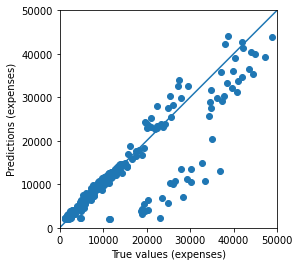

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set
loss, mae, mse = model.evaluate(test_features, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
